In [2]:
import pyspark as ps
from pyspark.sql.types import *
from pyspark.sql.functions import isnull, when, count, col
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt

# starts the spark session that uses: 4 cores, sql and rdd contexts
# note: this spark session only uses the local machine
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

# a sparkcontext which makes rdds
sc = spark.sparkContext

## ====LA starts here====

In [3]:
la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true')

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat|  start_lon|end_station|  end_lat|    end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+-----------+-----------+---------+-----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|34.035801|-118.233170|       3082|34.046520|-118.237411|  06518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00| 

In [9]:
la_sdf.describe().show()

+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|summary|             trip_id|          duration|   start_time|     end_time|    start_station|          start_lat|          start_lon|       end_station|            end_lat|            end_lon|           bike_id|     plan_duration|trip_route_category|passholder_type|
+-------+--------------------+------------------+-------------+-------------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+---------------+
|  count|              812210|            812210|       812210|       812210|           812210|             761956|             761956|            812210|             787561|             787561

In [10]:
la_sdf.count()

812210

In [18]:
# dataframe loses ~69,000 rows after dropping any that have null elements

la_sdf.dropna(how='any').count()

742859

In [16]:
# modified line from stack overflow, counts the number of null values in each column

la_sdf.select([count(when(isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|      0|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



So the only null values in the LA data are latitudes and longitudes. There must be one or more stations that don't have lat/long data. Since we aren't doing any mapping data, this shouldn't matter. We couldn't realistically calculate distance with these coordinates anyways.

In [19]:
la_sdf.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- start_station: string (nullable = true)
 |-- start_lat: string (nullable = true)
 |-- start_lon: string (nullable = true)
 |-- end_station: string (nullable = true)
 |-- end_lat: string (nullable = true)
 |-- end_lon: string (nullable = true)
 |-- bike_id: string (nullable = true)
 |-- plan_duration: string (nullable = true)
 |-- trip_route_category: string (nullable = true)
 |-- passholder_type: string (nullable = true)



In [4]:
# this time with schema

la_schema = StructType([
    StructField('trip_id', IntegerType(), True), # primary key
    StructField('duration', IntegerType(), True), # duration in minutes, may want to remove trips below 5 minutes or over x hours
    StructField('start_time', StringType(), True), # ISO 8601 (local time), TimestampType drops 1/3 of the data
    StructField('end_time', StringType(), True),
    StructField('start_station', IntegerType(), True), # foreign key, station names exist online somewhere
    StructField('start_lat', FloatType(), True), # useful if looking for geographic data
    StructField('start_lon', FloatType(), True),
    StructField('end_station', IntegerType(), True),
    StructField('end_lat', FloatType(), True),
    StructField('end_lon', FloatType(), True),
    StructField('bike_id', IntegerType(), True), # foreign key
    StructField('plan_duration', IntegerType(), True), # days rider has had their pass, 0 or 1 (?) for "walk up"
    StructField('trip_route_category', StringType(), True), # "Round Trip" or "One Way"
    StructField('passholder_type', StringType(), True)
    #, StructField('bike_type', StringType(), True)
])

la_folder = 'data/LA/'

la_sdf = spark.read.csv(la_folder, header='true', inferSchema=False, schema=la_schema)

# REMOVE LEAP DAY FROM 2020

la_sdf.show()

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00|         4147| 3

In [5]:
# If you want to run some certain analysis, start here with picking the relevant columns

use_cols = ['duration', 'start_time']
drop_cols = la_sdf.columns
for col in use_cols:
    drop_cols.remove(col)

la_sdf_to_pd = la_sdf.drop(*drop_cols)

la_sdf_to_pd.show()

+--------+-------------------+
|duration|         start_time|
+--------+-------------------+
|       8|2018-07-01 00:04:00|
|       8|2018-07-01 00:04:00|
|      15|2018-07-01 00:09:00|
|       7|2018-07-01 00:22:00|
|      35|2018-07-01 00:23:00|
|       6|2018-07-01 00:38:00|
|       5|2018-07-01 00:39:00|
|      33|2018-07-01 00:40:00|
|       6|2018-07-01 00:44:00|
|       3|2018-07-01 00:46:00|
|       7|2018-07-01 00:49:00|
|       7|2018-07-01 00:49:00|
|      19|2018-07-01 00:51:00|
|      19|2018-07-01 00:51:00|
|      16|2018-07-01 01:10:00|
|       2|2018-07-01 01:29:00|
|      21|2018-07-01 01:32:00|
|     383|2018-07-01 01:35:00|
|      17|2018-07-01 01:47:00|
|      17|2018-07-01 01:47:00|
+--------+-------------------+
only showing top 20 rows



There are trips that are below 3 minutes (duration = 2) where the rider made it from one station to another. So although the data will include rider or machine error that inflates the number of rides, at least for LA we can't realistically pull all the short trips without throwing out real data. An argument could be made for short "round trip" rows, but it's hard to say what the limit should be (2 minutes? 5? 10?).

In [6]:
la_df = la_sdf_to_pd.toPandas()

la_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812210 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   duration    812210 non-null  int32 
 1   start_time  812210 non-null  object
dtypes: int32(1), object(1)
memory usage: 9.3+ MB


In [7]:
# make our start_time column into a datetime format, remove feb 29th from 2020

la_df['start_time'] = pd.to_datetime(la_df['start_time'], infer_datetime_format=True)

la_df = la_df[~((la_df['start_time'].dt.month == 2) & (la_df['start_time'].dt.day == 29))]

la_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811227 entries, 0 to 812209
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   duration    811227 non-null  int32         
 1   start_time  811227 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 15.5 MB


In [79]:
# don't need this, cut later

dates_2018 = la_df[la_df['start_time'].dt.year == 2018].start_time.dt.date.unique()

dates_2018

array([datetime.date(2018, 7, 1), datetime.date(2018, 7, 2),
       datetime.date(2018, 7, 3), datetime.date(2018, 7, 4),
       datetime.date(2018, 7, 5), datetime.date(2018, 7, 6),
       datetime.date(2018, 7, 7), datetime.date(2018, 7, 8),
       datetime.date(2018, 7, 9), datetime.date(2018, 7, 10),
       datetime.date(2018, 7, 11), datetime.date(2018, 7, 12),
       datetime.date(2018, 7, 13), datetime.date(2018, 7, 14),
       datetime.date(2018, 7, 15), datetime.date(2018, 7, 16),
       datetime.date(2018, 7, 17), datetime.date(2018, 7, 18),
       datetime.date(2018, 7, 19), datetime.date(2018, 7, 20),
       datetime.date(2018, 7, 21), datetime.date(2018, 7, 22),
       datetime.date(2018, 7, 23), datetime.date(2018, 7, 24),
       datetime.date(2018, 7, 25), datetime.date(2018, 7, 26),
       datetime.date(2018, 7, 27), datetime.date(2018, 7, 28),
       datetime.date(2018, 7, 29), datetime.date(2018, 7, 30),
       datetime.date(2018, 7, 31), datetime.date(2018, 8, 1),
  

In [8]:
la_df_2018 = la_df[la_df['start_time'].dt.year == 2018]

la_df_2018 = la_df_2018.groupby(la_df_2018['start_time'].dt.month).size()

la_df_2019 = la_df[la_df['start_time'].dt.year == 2019]

la_df_2019 = la_df_2019.groupby(la_df_2019['start_time'].dt.month).size()

la_df_2020 = la_df[la_df['start_time'].dt.year == 2020]

la_df_2020 = la_df_2020.groupby(la_df_2020['start_time'].dt.month).size()

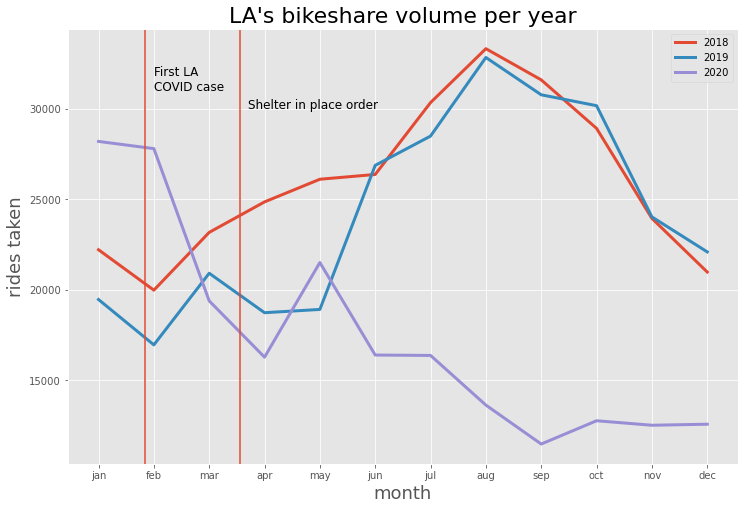

In [30]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12,8))

x = [1,2,3,4,5,6,7,8,9,10,11,12]

ax.plot(x, la_df_2018, label='2018', linewidth=3)
ax.plot(x, la_df_2019, label='2019', linewidth=3)
ax.plot(x, la_df_2020, label='2020', linewidth=3)
ax.axvline(x= 1 + 26/31)
ax.text(2, 31000, 'First LA\nCOVID case', fontsize=12)
ax.axvline(x= 3 + 17/31)
ax.text(3.7, 30000, 'Shelter in place order', fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('month', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("LA's bikeshare volume per year", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_volume.png');

do a graph of by the hour start times, one for each year?

then do another city I guess

find that graph I was looking at Friday afternoon

link for desc: https://data.world/makeovermonday/2021w1

In [41]:
# Jan/Feb kind of reduce effect size of pandemic in 2020, but leaving '18 and '19 with two extra months inflates the difference between years
# Solution: remove from all years

la_df_2018_hr = la_df[(la_df['start_time'].dt.year == 2018) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2018_hr = la_df_2018_hr.groupby(la_df_2018_hr['start_time'].dt.hour).size()

la_df_2019_hr = la_df[(la_df['start_time'].dt.year == 2019) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2019_hr = la_df_2019_hr.groupby(la_df_2019_hr['start_time'].dt.hour).size()

la_df_2020_hr = la_df[(la_df['start_time'].dt.year == 2020) & (la_df['start_time'].dt.month != 1) & (la_df['start_time'].dt.month != 2)]
la_df_2020_hr = la_df_2020_hr.groupby(la_df_2020_hr['start_time'].dt.hour).size()

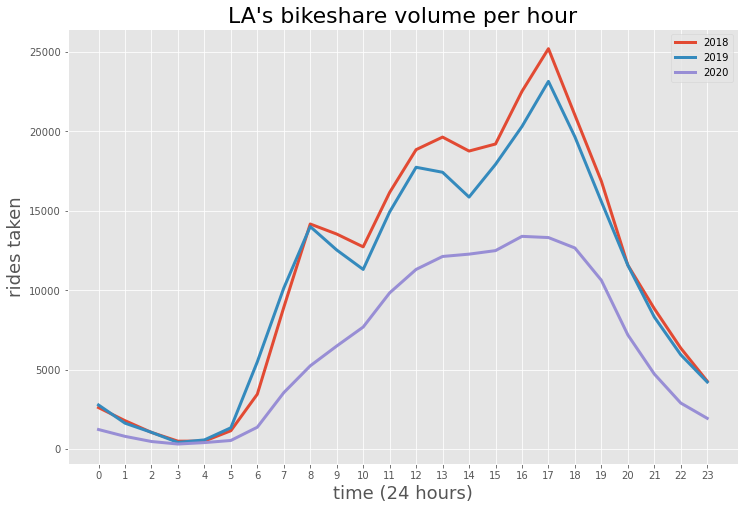

In [44]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12,8))

x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

ax.plot(x, la_df_2018_hr, label='2018', linewidth=3)
ax.plot(x, la_df_2019_hr, label='2019', linewidth=3)
ax.plot(x, la_df_2020_hr, label='2020', linewidth=3)

ax.set_xticks(x)
#ax.set_xticklabels(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

ax.set_xlabel('time (24 hours)', fontsize=18)
ax.set_ylabel('rides taken', fontsize=18)
ax.set_title("LA's bikeshare volume per hour", fontsize=22)

ax.legend();

#plt.savefig('graphs/la_hour.png');

Important note: in graph above Jan and Feb were excluded from all years to make a more balanced comparison

## ====Chicago starts here====

In [73]:
# Chicago changes their layout right after 2018 Q1, so you need to clean this one separately
# Two zip files also came out without the .csv in their file name, needs to be manually added

ch_sdf_Q1 = spark.read.csv('data/CH/Divvy_Trips_2018_Q1.csv', header='true')

#ch_sdf_Q1.printSchema()

use_cols = ['01 - Rental Details Duration In Seconds Uncapped', '01 - Rental Details Local Start Time']
drop_cols = ch_sdf_Q1.columns
for col in use_cols:
    drop_cols.remove(col)

ch_sdf_Q1 = (ch_sdf_Q1.drop(*drop_cols)
             .withColumnRenamed('01 - Rental Details Duration In Seconds Uncapped', 'tripduration')
             .withColumnRenamed('01 - Rental Details Local Start Time', 'start_time'))

ch_sdf_Q1.printSchema()

root
 |-- start_time: string (nullable = true)
 |-- tripduration: string (nullable = true)



In [81]:
# verbose way of getting the rest of the files into a df

filelist = []
for quarter in [2,3,4]:
    filelist.append('data/CH/Divvy_Trips_2018_Q{}.csv'.format(quarter))
for quarter in [1,2,3,4]:
    filelist.append('data/CH/Divvy_Trips_2019_Q{}.csv'.format(quarter))
filelist.append('data/CH/Divvy_Trips_2020_Q1.csv')
for month in range(4,13):
    filelist.append('data/CH/2020{0:0=2d}-divvy-tripdata.csv'.format(month))

ch_sdf = spark.read.csv(filelist, header='true')

ch_sdf.count()

10575624

In [ ]:
# RETURN HERE: time to concat chicago into one df then port it to pandas

In [51]:
# looking for null data, why is there null data in tripduration?
# rows w/ less than 60 seconds already removed

ch_sdf.select([count(when(isnull(c), c)).alias(c) for c in ch_sdf.columns]).show()

+-------+----------+--------+------+------------+---------------+-----------------+-------------+---------------+--------+-------+---------+
|trip_id|start_time|end_time|bikeid|tripduration|from_station_id|from_station_name|to_station_id|to_station_name|usertype| gender|birthyear|
+-------+----------+--------+------+------------+---------------+-----------------+-------------+---------------+--------+-------+---------+
|      0|         0|       0|     0|       94656|          95282|           110881|       111342|              0|       0|1125966|  1098215|
+-------+----------+--------+------+------------+---------------+-----------------+-------------+---------------+--------+-------+---------+



In [56]:
ch_sdf.filter(ch_sdf.tripduration.isNull()).show()

+----------------+-------------+-------------------+-------------------+------------+---------------+--------------------+-------------+---------------+--------+------------------+------------------+
|         trip_id|   start_time|           end_time|             bikeid|tripduration|from_station_id|   from_station_name|to_station_id|to_station_name|usertype|            gender|         birthyear|
+----------------+-------------+-------------------+-------------------+------------+---------------+--------------------+-------------+---------------+--------+------------------+------------------+
|CBE132DC5360F780|electric_bike|2020-08-27 09:07:44|2020-08-27 09:32:45|        null|           null|Clinton St & Roos...|           57|          41.85|  -87.69|41.867185166666665|-87.64104866666666|
|C106B2A1A15BF053|electric_bike|2020-08-27 18:58:47|2020-08-27 20:18:24|        null|           null|                null|         null|          41.87|  -87.61|             41.85|            -87.62|


In [57]:
ch_sdf.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- start_time: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- bikeid: string (nullable = true)
 |-- tripduration: string (nullable = true)
 |-- from_station_id: string (nullable = true)
 |-- from_station_name: string (nullable = true)
 |-- to_station_id: string (nullable = true)
 |-- to_station_name: string (nullable = true)
 |-- usertype: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthyear: string (nullable = true)

